<a href="https://colab.research.google.com/github/RobertShehu/Colab/blob/main/car_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [3]:
IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
path = '/content/drive/MyDrive/'
class_names = os.listdir(path+'Progetto')
depth = len(class_names)

In [4]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    path+'Progetto',
    labels='inferred',
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    path+'Progetto',
    labels='inferred',
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Found 8667 files belonging to 23 classes.
Using 7801 files for training.
Found 8667 files belonging to 23 classes.
Using 866 files for validation.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(1),
  tf.keras.layers.RandomContrast(0.2)
])

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.Flatten()


prediction_layer = keras.layers.Dense(depth, activation='softmax')

model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  global_average_layer,
  prediction_layer
])

In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('final_model.h5', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.001)

callbacks = [checkpoint, earlystop, reduce_lr]

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(ds_validation, steps=validation_steps)

In [ ]:
print(model.summary())

In [ ]:
initial_epochs = 20
history = model.fit(ds_train, epochs=initial_epochs, validation_data=ds_validation, callbacks=callbacks)
acc = history.history['accuracy']
print(acc)
model.save("final_model.h5")

In [ ]:
model_dir="/content/final_model.h5"
cars_model=tf.keras.models.load_model(model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(cars_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('new_cars_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [5]:
cars_model = tf.keras.models.load_model("/content/drive/MyDrive/Modelli/final_model.h5")

In [6]:
classes = ds_train.class_names
print(classes)
element, label = ds_validation.as_numpy_iterator().next()

['Audi_A3', 'Audi_A4', 'Audi_A5', 'Audi_TT', 'BMW_3-Series', 'BMW_5-Series', 'BMW_X3', 'BMW_X6', 'FIAT_500', 'Ford_Fiesta', 'Honda_Civic', 'Jeep_Grand Cherokee', 'Lexus_IS', 'MINI_Cooper', 'Mazda_MAZDA3', 'Mazda_MX-5 Miata', 'Mercedes-Benz_C Class', 'Porsche_Cayenne', 'Toyota_Corolla', 'Toyota_Yaris', 'Volkswagen_Beetle', 'Volkswagen_Golf', 'Volvo_XC90']


Volkswagen_Beetle 100.0%: OK
Ford_Fiesta 87.48825192451477%: OK
Toyota_Corolla 74.87077116966248%: NO, it's a Honda_Civic
Jeep_Grand Cherokee 52.036118507385254%: NO, it's a Ford_Fiesta
Volkswagen_Beetle 55.204105377197266%: NO, it's a Porsche_Cayenne
Volkswagen_Beetle 17.222708463668823%: NO, it's a Honda_Civic
BMW_X3 99.34472441673279%: OK
Audi_TT 54.91034388542175%: NO, it's a Audi_A5
Volkswagen_Beetle 68.85734796524048%: OK
BMW_5-Series 67.41026043891907%: OK
Mercedes-Benz_C Class 92.60949492454529%: OK
Porsche_Cayenne 68.75133514404297%: NO, it's a Mazda_MX-5 Miata
Mazda_MX-5 Miata 83.1294596195221%: OK
BMW_X3 76.92065238952637%: OK
MINI_Cooper 99.99876022338867%: OK
Mercedes-Benz_C Class 37.63304054737091%: NO, it's a Honda_Civic
Porsche_Cayenne 57.21769332885742%: NO, it's a Lexus_IS
Honda_Civic 77.30275392532349%: OK
Mazda_MAZDA3 97.68311977386475%: OK
Audi_A4 80.43111562728882%: NO, it's a Audi_TT
MINI_Cooper 46.9837486743927%: OK
Volkswagen_Beetle 100.0%: OK
Toyota_Corolla 99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


BMW_3-Series 41.53776168823242%: NO, it's a Audi_A4
Mazda_MAZDA3 41.867512464523315%: NO, it's a Toyota_Corolla


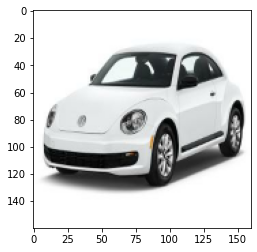

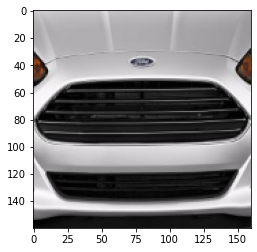

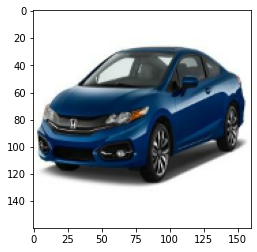

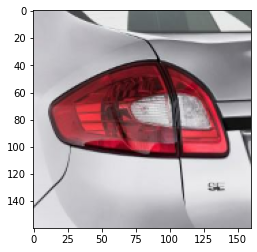

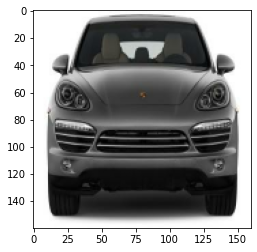

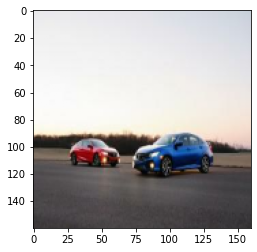

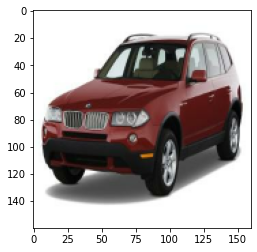

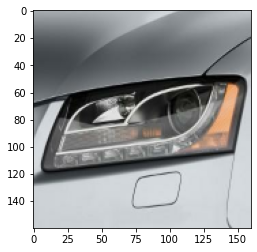

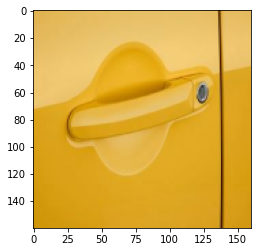

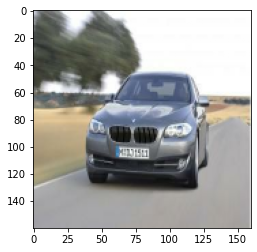

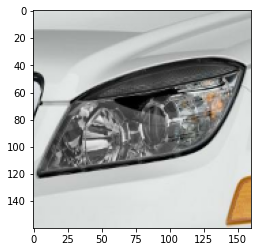

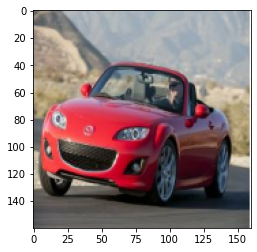

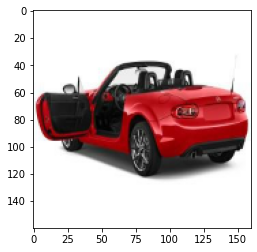

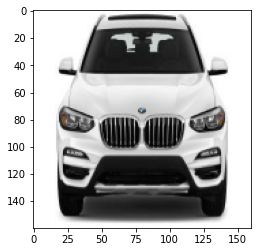

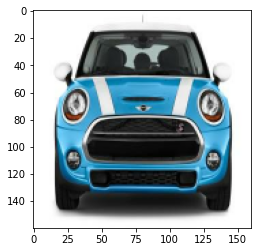

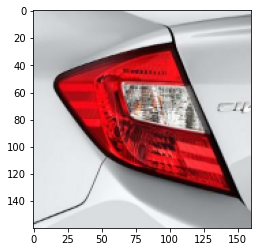

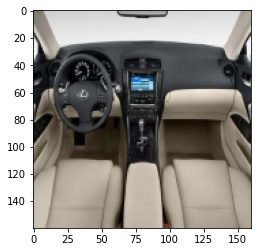

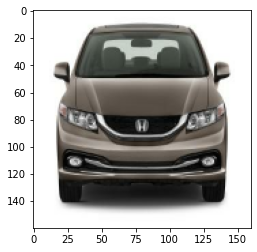

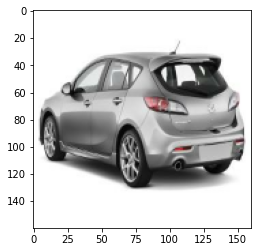

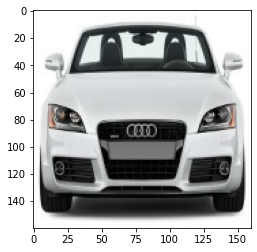

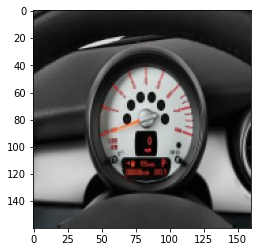

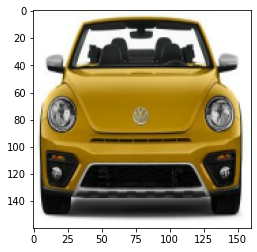

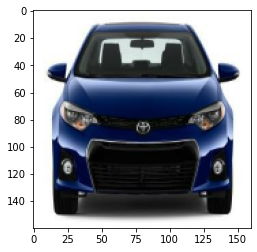

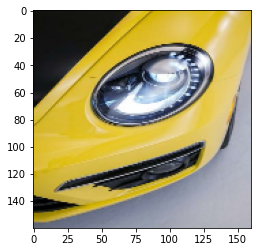

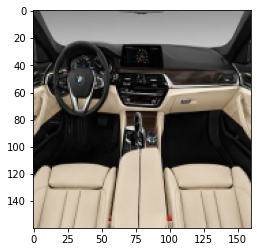

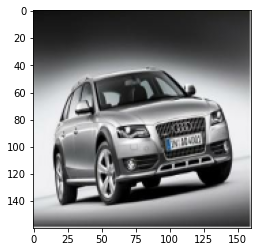

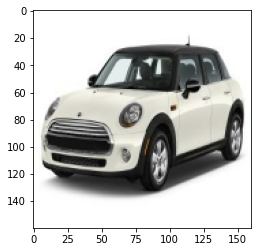

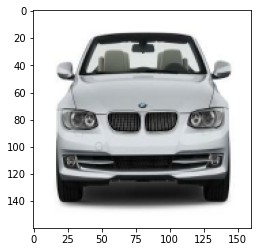

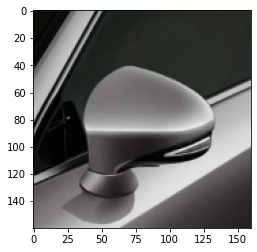

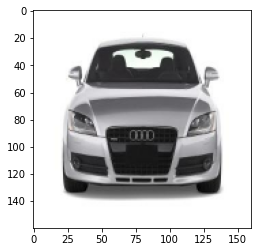

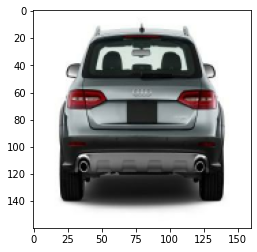

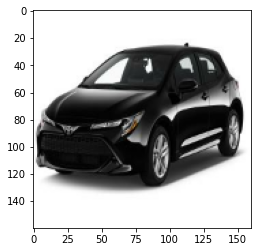

In [28]:
predictions = cars_model.predict(element)
for i in range(32):
  plt.figure()
  fig = element[i]/255.0
  plt.imshow(fig)
  pred_class = classes[np.argmax(predictions[i])]
  true_class = classes[label[i]]
  if (pred_class == true_class):
    print(pred_class+" "+str(np.max(predictions[i])*100)+"%: OK")
  else:
    print(pred_class+" "+str(np.max(predictions[i])*100)+"%: NO, it's a "+true_class)